In [1]:
from data_generators import get_iterator, get_dataset
from classifiers import theme_classifier
import torch
import torch.nn as nn
from torchtext.vocab import GloVe 
GLOVE_EMBEDDING = GloVe(name="6B", dim=300)

In [2]:
train_dataset, val_dataset, test_dataset, review_text_FIELD, theme_FIELD = get_dataset(vectors = GLOVE_EMBEDDING)

In [3]:
batch_size = 100
train_iter = get_iterator(train_dataset, batch_size, train=True, shuffle=True, repeat=False)
val_iter = get_iterator(val_dataset, batch_size, train=False, shuffle=True, repeat=False)
test_iter = get_iterator(test_dataset, batch_size, train=False, shuffle=True, repeat=False)

In [4]:
val_list = list(val_iter)

In [5]:
from baseline_model import BaseModel, repackage_hidden

In [6]:
vocab_size = 12304

In [7]:
import numpy as np
from torch.autograd import Variable
from torch.distributions import Categorical

In [198]:
def select_action(policy, state, top_k = 10):
    data, labels, hidden = state
    
    state, hidden = policy(data, labels, hidden)
    #state = torch.softmax(state, -1)
    
    sorted_states, indexes = torch.topk(state, top_k, -1)
    sorted_states = torch.softmax(sorted_states, -1)
    
    c = Categorical(sorted_states)
    i_action =  c.sample()
    action = i_action.unsqueeze(-1)
    action = torch.gather(indexes, 2, action)
    action = action.squeeze(-1)
    
    prob = torch.exp(c.log_prob(i_action).cuda())
    
    if len(policy.policy_history.shape) != 0:
        policy.policy_history = torch.cat([policy.policy_history.cuda(), prob.unsqueeze(0)])
        policy.policy_actions = torch.cat([policy.policy_actions.cuda(), action.unsqueeze(0)])
    else:
        policy.policy_history = prob
        policy.policy_actions = action
        
    return action, prob, hidden

In [390]:
def transtaltion2string(raw_translations, target_vocab = review_text_FIELD, max_words=30000):
    string_translations = []
    for raw_sentence in raw_translations:
        string_sentence = []
        for i, word_idx in enumerate(raw_sentence):
            if i == max_words: break
            word = target_vocab.vocab.itos[word_idx]
            if word == '<eos>':
                break
            if word != '<sos>':
                string_sentence.append(word)
        string_translations.append(string_sentence)
    return [' '.join(_) for _ in string_translations]


def update_policy(policy, labels, optimizer, verbose=False):

    policy_actions = policy.policy_actions.squeeze(1)
    predictions = []
    for i in range(policy_actions.shape[1]):
        predicted_class = theme_classifier(transtaltion2string([policy_actions[:,i]])[0])
        idx_class = theme_FIELD.vocab.stoi[predicted_class] - 1 
        predictions.append(idx_class)
    predictions = torch.tensor(predictions).cuda()

    classifier_output = (predictions == labels).float()
    if verbose: print('acc', classifier_output.mean().item())
    classifier_output[classifier_output==0] = -2
    classifier_output[classifier_output==1] = 2

    # Calculate loss
    loss = torch.mul(policy.policy_history.squeeze(1), 
                                Variable(classifier_output)).mul(-1)
    loss = loss.sum()
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = Variable(torch.Tensor()).cuda()
    policy.reward_episode= []

In [391]:
EOS_token = review_text_FIELD.vocab.stoi['<eos>']
EOS_token

3

In [393]:
def main(episodes, policy, optimizer, source, top_k):
    
    for episode in range(episodes):
        
        labels = source.theme.cuda().long() - 1
        data = source.review_text.cuda().long()
        
        hidden = None
        action = data[0,:].unsqueeze(0)
        for time in range(data.shape[0]): #seq_len!!!
            action, prob, hidden = select_action(policy, state=(action, labels, hidden), top_k=top_k)#+time)
            
            policy.reward_episode.append(prob/episodes)
        
        update_policy(policy, labels, optimizer, episode % (episodes-1) == 0)
        
        reward_history = [x.mean().item() for x in policy.reward_history]
        
        if episode % (episodes-1) == 0:
            print('Episode {}\tLast seq_len: {:5d}\tAverage reward: {:.2f}'.format(episode, time, 
                                                                                 np.mean(reward_history)))
            
    print('\n\n')

In [394]:
if False:
    for i, batch in enumerate(val_list):
        labels = batch.theme.cuda().long() - 1
        batch = batch.review_text.cuda().long()
        if batch.shape[0] > 3:
            print(i)
            break
    ok_val_list = val_list[i:]

In [395]:
class ReinforcedModel(nn.Module):

    def __init__(self, base_model, gamma):
        super().__init__()

        self.base_model = base_model.cuda()
        self.gamma = gamma

        self.policy_history = Variable(torch.Tensor()).cuda()
        self.policy_actions = Variable(torch.Tensor()).cuda().long()
        self.reward_episode = []
        self.reward_history = []
        self.loss_history = []

    def forward(self, data, labels, hidden):    
        x = self.base_model(data, labels, hidden)
        return x

In [396]:
if True:
    with open('./baseline/best_model_base_model_ppl_67.5461793533482.model', 'rb') as file:
        model = torch.load(file)
        model.eval()
    model.train()
    policy = ReinforcedModel(model, 0.99).cuda()
    
    import torch.optim as optim
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)

In [397]:
from utils_fns import evaluate

In [398]:
criterion = nn.CrossEntropyLoss(reduction='mean',
                       ignore_index=train_dataset.fields["review_text"].vocab.stoi['<pad>']).cuda()
#evaluate(model, ok_val_list, criterion)

In [399]:
episodes = 5
for i, batch in enumerate(train_iter):
    b = batch.review_text.cuda().long()
    if b.shape[0] <= 3: continue
    if i == 50: break
    main(episodes, policy, optimizer, batch, top_k=5)

acc 0.9899999499320984
Episode 0	Last seq_len:     3	Average reward: 0.31
acc 1.0
Episode 4	Last seq_len:     3	Average reward: 0.33



acc 0.8899999856948853
Episode 0	Last seq_len:     3	Average reward: 0.33
acc 0.9199999570846558
Episode 4	Last seq_len:     3	Average reward: 0.36



acc 0.9199999570846558
Episode 0	Last seq_len:     3	Average reward: 0.37
acc 0.9399999976158142
Episode 4	Last seq_len:     3	Average reward: 0.41



acc 0.8700000047683716
Episode 0	Last seq_len:     3	Average reward: 0.42
acc 0.8799999952316284
Episode 4	Last seq_len:     3	Average reward: 0.46



acc 0.8499999642372131
Episode 0	Last seq_len:     3	Average reward: 0.47
acc 0.8499999642372131
Episode 4	Last seq_len:     3	Average reward: 0.51



acc 0.8299999833106995
Episode 0	Last seq_len:     3	Average reward: 0.51
acc 0.8299999833106995
Episode 4	Last seq_len:     3	Average reward: 0.54



acc 0.8799999952316284
Episode 0	Last seq_len:     3	Average reward: 0.55
acc 0.8799999952316284
Episode 4	La

In [400]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

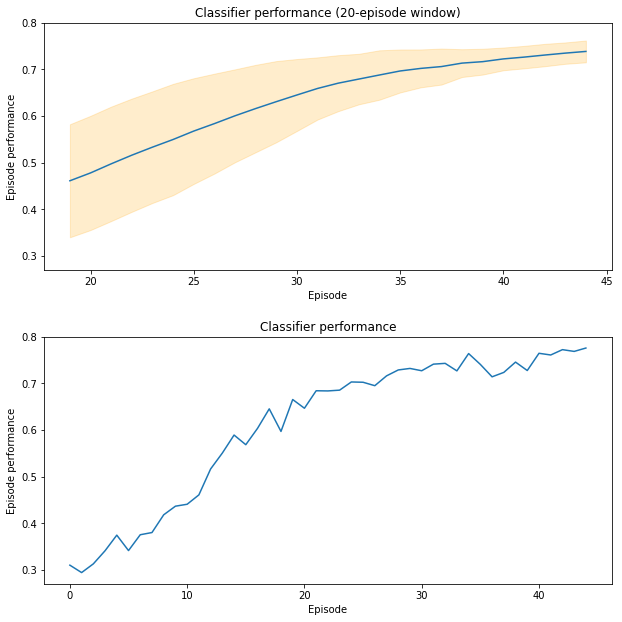

In [403]:
window = 20#int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);

reward_history = [x.mean() for x in policy.reward_history]

rolling_mean = pd.Series(reward_history).rolling(window).mean()
std = pd.Series(reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Classifier performance ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode performance')

ax2.plot(reward_history)
ax2.set_title('Classifier performance')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode performance')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')

